In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

In [2]:
"""
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
"""

"\nnltk.download('stopwords')\nnltk.download('wordnet')\nnltk.download('punkt')\nnltk.download('omw-1.4')\n"

#### Chargement de donn√©es

In [3]:
df = pd.read_csv('data\overflowdata.csv')

#### D√©xouverte de donn√©es

In [4]:
df.shape

(50000, 8)

In [5]:
df.head(5)

Title   
0  How to wait for all threads to finish, using E...  \
1  How to base64 encode /dev/random or /dev/urandom?   
2  Cross-browser checking on file size at client ...   
3  How to pass a variable from one app domain to ...   
4     Finding points on a line with a given distance   

                                                Body   
0  <p>I need to execute some amount of tasks 4 at...  \
1  <p><code>cat /dev/urandom</code> is always a f...   
2  <p>Client side validation is important to impr...   
3  <p>I'd like to know, if I have a variable,for ...   
4  <p>I have a question i know a line i just know...   

                                                Tags       Id  Score   
0  <java><multithreading><concurrency><parallel-p...  1250643    454  \
1            <bash><linux><base64><uuencode><random>  1250144     45   
2  <asp.net><validation><file-upload><cross-brows...  1250414      5   
3        <c#><.net><vb.net><cross-domain><appdomain>  1250676     15   
4  <language-agnostic><graphics><vector><lines><p...  1250419     25   

   ViewCount  FavoriteCount  AnswerCount  
0     418421            0.0           27  
1      55275            0.0            7  
2       6956            NaN            2  
3      14751            0.0            3  
4      23994            0.0            5

In [6]:
df.tail()

Title   
49995            Extjs Ajax file download request C# MVC  \
49996  WebDeploy with MSBuild Not Deploying from Team...   
49997  Detect release / debug in gulp using Visual St...   
49998                       Index a NumPy array row-wise   
49999                              Get cookie with react   

                                                    Body   
49995  <p>I want client to download a file stored on ...  \
49996  <p>I am trying to use MSDeploy to deploy an MV...   
49997  <p>I've set up an ASP.NET 5 project in Visual ...   
49998  <p>Say I have a NumPy array:</p>\n\n<pre><code...   
49999  <p>I need to know if my user is connected or n...   

                                                    Tags        Id  Score   
49995                   <c#><ajax><extjs><get><download>  14235896      6  \
49996  <msbuild><visual-studio-2012><teamcity><msdepl...  14235960     10   
49997  <asp.net><configuration><typescript><gulp><vis...  31712324     36   
49998    <python><arrays><numpy><optimization><indexing>  48997698      5   
49999  <reactjs><session><cookies><express-session><r...  51109559     83   

       ViewCount  FavoriteCount  AnswerCount  
49995       3876            0.0            2  
49996      11081            0.0            6  
49997       9054            0.0            8  
49998       1360            0.0            4  
49999     245819            0.0            8

In [7]:
df.describe()

Id         Score     ViewCount  FavoriteCount   AnswerCount
count  5.000000e+04  50000.000000  5.000000e+04   43065.000000  50000.000000
mean   2.184892e+07     34.642020  3.502015e+04       0.000813      4.335220
std    1.783437e+07    214.428755  1.346047e+05       0.154427      4.048137
min    4.000000e+00      5.000000  5.600000e+01       0.000000      2.000000
25%    8.454510e+06      6.000000  3.638000e+03       0.000000      2.000000
50%    1.780447e+07     10.000000  9.445500e+03       0.000000      3.000000
75%    3.341671e+07     20.000000  2.557250e+04       0.000000      5.000000
max    7.170600e+07  26981.000000  5.990593e+06      32.000000    126.000000

In [8]:
df.dtypes

Title             object
Body              object
Tags              object
Id                 int64
Score              int64
ViewCount          int64
FavoriteCount    float64
AnswerCount        int64
dtype: object

In [9]:
df.nunique()

Title            49999
Body             50000
Tags             49090
Id               50000
Score              797
ViewCount        28485
FavoriteCount        3
AnswerCount         63
dtype: int64

In [10]:
df.isnull().sum()

Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
FavoriteCount    6935
AnswerCount         0
dtype: int64

In [11]:
df.duplicated(subset="Title").sum()

1

### D√©finition des fonctions de nettoyage

##### fonction de nettoyage des balises html

In [12]:
# D√©finir une fonction pour nettoyer le html d'une cha√Æne
def clean_html(string):
# Cr√©er un objet BeautifulSoup √† partir de la cha√Æne
    soup = BeautifulSoup(string, "html.parser")
    # Extraire le texte de l'objet BeautifulSoup en ignorant les balises
    text = soup.get_text()
    return text

##### Fonction de lemmatization
(Tokenizer les phrases, nettoyage des stopwords et caract√®res sp√©ciaux, lemmatisation)

In [13]:
# D√©finir une fonction pour lemmatiser une phrase
def lemmatize_sentence(sentence):

    # Tokeniser la phrase en mots
    words = nltk.word_tokenize(sentence)
    stopwords = nltk.corpus.stopwords.words('english') + ['[', ']', ',', '.', ':', '?', '(', ')']

    words_w_stopwords = [i for i in words if i not in stopwords]

    # Lemmatiser chaque mot et reconstruire la phrase
    wnl = WordNetLemmatizer()
    lemmatized_words = [wnl.lemmatize(word) for word in words_w_stopwords]
    lemmatized_sentence = " ".join(lemmatized_words)

    return lemmatized_sentence

##### Application des fonctions de nettoyage

Nettoyage balises html de la colonne Body

In [14]:
# Appliquer la fonction clean_html √† la colonne Body du dataframe
df['Body_cleaned'] = df['Body'].apply(clean_html)

# Afficher le r√©sultat
df['Body_cleaned']

0        I need to execute some amount of tasks 4 at a ...
1        cat /dev/urandom is always a fun way to create...
2        Client side validation is important to improve...
3        I'd like to know, if I have a variable,for exa...
4        I have a question i know a line i just know it...
                               ...                        
49995    I want client to download a file stored on my ...
49996    I am trying to use MSDeploy to deploy an MVC p...
49997    I've set up an ASP.NET 5 project in Visual Stu...
49998    Say I have a NumPy array:\n>>> X = np.array([[...
49999    I need to know if my user is connected or not....
Name: Body_cleaned, Length: 50000, dtype: object

Lemmatization de la colonne Body

In [15]:
# Appliquer la fonction lemmatize_sentence √† la colonne body du dataframe
df['Body_lemmatized'] = df['Body_cleaned'].apply(lemmatize_sentence)

# Afficher le r√©sultat
df['Body_lemmatized']


0        I need execute amount task 4 time something li...
1        cat /dev/urandom always fun way create scrolli...
2        Client side validation important improve usabi...
3        I 'd like know I variable example string pas v...
4        I question know line know slope point A x How ...
                               ...                        
49995    I want client download file stored db clicked ...
49996    I trying use MSDeploy deploy MVC project serve...
49997    I 've set ASP.NET 5 project Visual Studio crea...
49998    Say I NumPy array > > > X = np.array 1 2 3 4 5...
49999    I need know user connected For I want read coo...
Name: Body_lemmatized, Length: 50000, dtype: object

Lemmatization de la colonne Title

In [16]:
# Appliquer la fonction √† la colonne title du dataframe
df['Title_lemmatized'] = df['Title'].apply(lemmatize_sentence)

# Afficher le r√©sultat
df['Title_lemmatized']

0             How wait thread finish using ExecutorService
1               How base64 encode /dev/random /dev/urandom
2        Cross-browser checking file size client side u...
3                  How pas variable one app domain another
4                        Finding point line given distance
                               ...                        
49995             Extjs Ajax file download request C # MVC
49996             WebDeploy MSBuild Not Deploying TeamCity
49997    Detect release / debug gulp using Visual Studi...
49998                           Index NumPy array row-wise
49999                                     Get cookie react
Name: Title_lemmatized, Length: 50000, dtype: object

Nettoyage de la colonne Tags des balises <>

In [17]:
df['Tags'] = df['Tags'].str.replace('<', '').str.replace('>', ' ')

df['Tags'] = df['Tags'].str.split()

# Afficher le r√©sultat
print(df['Tags'])

0        [java, multithreading, concurrency, parallel-p...
1                  [bash, linux, base64, uuencode, random]
2        [asp.net, validation, file-upload, cross-brows...
3              [c#, .net, vb.net, cross-domain, appdomain]
4        [language-agnostic, graphics, vector, lines, p...
                               ...                        
49995                     [c#, ajax, extjs, get, download]
49996    [msbuild, visual-studio-2012, teamcity, msdepl...
49997    [asp.net, configuration, typescript, gulp, vis...
49998      [python, arrays, numpy, optimization, indexing]
49999    [reactjs, session, cookies, express-session, r...
Name: Tags, Length: 50000, dtype: object


D√©finition d'un nouveau dataframe avec les deux colonnes Title et Body lemmatiz√©

In [18]:
df.columns

Index(['Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount', 'Body_cleaned', 'Body_lemmatized', 'Title_lemmatized'],
      dtype='object')

In [20]:
# afficher jusqu'√† 100 caract√®res par colonne
pd.set_option('display.max_colwidth', 100)

# afficher tout le texte sans tronquer
pd.set_option('display.max_colwidth', None)

In [21]:
df.loc[df['Id'] == 1250643,('Tags','Body', 'Body_cleaned', 'Body_lemmatized')]

Tags   
0  [java, multithreading, concurrency, parallel-processing, executorservice]  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Body   
0  <p>I need to execute some amount of tasks 4 at a time, something like this:</p>\n\n<pre><code>ExecutorService taskExecutor = Executors.newFixedThreadPool(4);\nwhile(...) {\n    taskExecutor.execute(new MyTask());\n}\n//...wait for completion somehow\n</code></pre>\n\n<p>How can I get notified once all of them are complete? For now I can't think about anything better than setting some global task counter and decrease it at the end of every task, then monitor in infinite loop this counter to become 0; or get a list of Futures and in infinite loop monitor isDone for all of them. What are better solutions not involving infinite loops?</p>\n\n<p>Thanks.</p>\n  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Body_cleaned   
0  I need to execute some amount of tasks 4 at a time, something like this:\nExecutorService taskExecutor = Executors.newFixedThreadPool(4);\nwhile(...) {\n    taskExecutor.execute(new MyTask());\n}\n//...wait for completion somehow\n\nHow can I get notified once all of them are complete? For now I can't think about anything better than setting some global task counter and decrease it at the end of every task, then monitor in infinite loop this counter to become 0; or get a list of Futures and in infinite loop monitor isDone for all of them. What are better solutions not involving infinite loops?\nThanks.\n  \

                                                                                                                                                                                                                                                                                                                                                                                                                                           Body_lemmatized  
0  I need execute amount task 4 time something like ExecutorService taskExecutor = Executors.newFixedThreadPool 4 ; ... { taskExecutor.execute new MyTask ; } // ... wait completion somehow How I get notified complete For I ca n't think anything better setting global task counter decrease end every task monitor infinite loop counter become 0 ; get list Futures infinite loop monitor isDone What better solution involving infinite loop Thanks

In [22]:
data = df.drop(['Title','Id', 'Score', 'ViewCount', 'FavoriteCount', 'AnswerCount', 'Body', 'Body_cleaned'], axis=1)

In [23]:
data

Tags   
0      [java, multithreading, concurrency, parallel-processing, executorservice]  \
1                                        [bash, linux, base64, uuencode, random]   
2                      [asp.net, validation, file-upload, cross-browser, client]   
3                                    [c#, .net, vb.net, cross-domain, appdomain]   
4                           [language-agnostic, graphics, vector, lines, points]   
...                                                                          ...   
49995                                           [c#, ajax, extjs, get, download]   
49996               [msbuild, visual-studio-2012, teamcity, msdeploy, webdeploy]   
49997             [asp.net, configuration, typescript, gulp, visual-studio-2015]   
49998                            [python, arrays, numpy, optimization, indexing]   
49999                 [reactjs, session, cookies, express-session, react-cookie]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Body_lemmatized   
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              I need execute amount task 4 time something like ExecutorService taskExecutor = Executors.newFixedThreadPool 4 ; ... { taskExecutor.execute new MyTask ; } // ... wait completion somehow How I get notified complete For I ca n't think anything better setting global task counter decrease end every task monitor infinite loop counter become 0 ; get list Futures infinite loop monitor isDone What better solution involving infinite loop Thanks  \
1                                      

In [24]:
#Renommer les colonnes 
data = data.rename(columns={'Body_lemmatized': 'Body'})
data = data.rename(columns={'Title_lemmatized': 'Title'})

#### Repr√©sentation des mots de la colonne Title en WordCloud

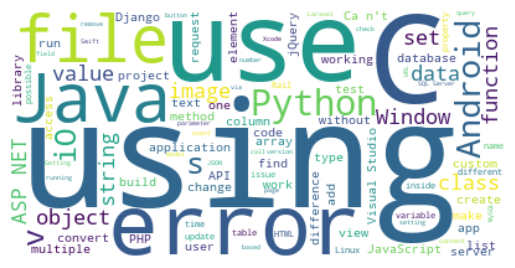

In [25]:
# Extraire la colonne des titres
titles = data['Title']

# Concat√©ner les titres en une seule cha√Æne de texte
text = " ".join(title for title in titles)

# Cr√©er un objet WordCloud
wc = WordCloud(background_color="white", max_words=100)

# G√©n√©rer le nuage de mots √† partir du texte
wc.generate(text)

# Afficher le nuage de mots
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

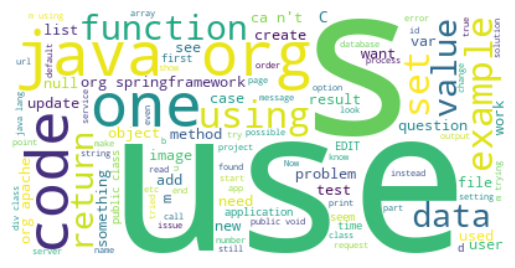

In [26]:
# Extraire la colonne des titres
titles = data['Body']

# Concat√©ner les titres en une seule cha√Æne de texte
text = " ".join(title for title in titles)

# Cr√©er un objet WordCloud
wc = WordCloud(background_color="white", max_words=100)

# G√©n√©rer le nuage de mots √† partir du texte
wc.generate(text)

# Afficher le nuage de mots
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
data = data.dropna()

In [28]:
data.to_csv('data\dataframe.csv', encoding='utf-8', index=False, errors='ignore')

### Bag of words

1 - CountVectorizer

In [29]:
# Cr√©er une instance de CountVectorizer
vectorizer = CountVectorizer(lowercase=True,  ngram_range=(1,2), min_df=5, max_df=0.8)

df_train, df_test = train_test_split(data, test_size=0.2)

vectorizer.fit(df_train['Title'])

df_test['quest'] = df_test['Title'] + ' ' + df_test['Body']

# Appliquer le transformeur sur la colonne quest
counts_test_quest = vectorizer.transform(df_test['quest'])


vocab = vectorizer.get_feature_names()

counts = pd.DataFrame(counts_test_quest.toarray(), columns=vocab)



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2 - TfidfVectorizer

In [30]:
tf_vectorizer = TfidfVectorizer(lowercase=True,  ngram_range=(1,2), min_df=5, max_df=0.8)

df_train, df_test = train_test_split(data, test_size=0.2)

tf_vectorizer.fit(df_train['Title'])

# Cr√©er une nouvelle colonne quest qui concat√®ne Title et Body
df_test['quest'] = df_test['Title'] + ' ' + df_test['Body']

# Appliquer le transformeur sur la colonne quest
tdf_counts= tf_vectorizer.transform(df_test['quest'])

tf_vocab = tf_vectorizer.get_feature_names()


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
# Afficher les scores tf-idf de chaque mot pour chaque document
for i, doc in enumerate(df_test['quest']):
    print(f"Document {i}: {doc}")

for j, word in enumerate(vocab):
    if tdf_counts[i,j] > 0:
        print(f"{word}: {tdf_counts[i,j]:.3f}")
    print()

Document 8887: Why chrome struggle display lot image canvas browser n't We 're working HTML5 canvas displaying lot image one time This working pretty well recently 've problem chrome When drawing image canvas seem reach certain point performance degrades quickly It 's slow effect seems go right 60fps 2-4fps Here 's reproduction code // Helpers // http //developer.mozilla.org/en-US/docs/JavaScript/Reference/Global_Objects/Math/random function getRandomInt min max { return Math.floor Math.random * max - min + 1 + min ; } // http //www.paulirish.com/2011/requestanimationframe-for-smart-animating/ window.requestAnimFrame = function { return window.requestAnimationFrame || window.webkitRequestAnimationFrame || window.mozRequestAnimationFrame || function callback { window.setTimeout callback 1000 / 60 ; } ; } ; // http //github.com/mrdoob/stats.js var Stats = function { var e = Date.now = e ; var n = 0 r = Infinity = 0 ; var = 0 = Infinity u = 0 ; var = 0 f = 0 ; var l = document.createEleme

In [32]:
# afficher la taille du dataframe df_test
print(df_test.shape)

# afficher les premi√®res lignes du dataframe df_test
print(df_test.head())

# afficher la taille de la matrice tdf_counts
print(tdf_counts.shape)

# afficher le nombre de valeurs non nulles dans la matrice tdf_counts
print(tdf_counts.nnz)

(10000, 4)
                                                                                                 Tags   
30312                                                [php, mysql, indexing, duplicates, unique-index]  \
42403                                  [windows, upload, automation, amazon-ec2, amazon-web-services]   
24755                                                     [ios, iphone, ipad, xamarin, xamarin.forms]   
13996                                                           [php, debugging, xampp, wamp, xdebug]   
5046   [android, android-recyclerview, android-room, android-architecture-components, android-paging]   

                                                                                                                                                                                                                                                                                                                                                                      